<a href="https://colab.research.google.com/github/microprediction/timeseries-notebooks/blob/main/tigramite_hello.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tigramite

     |████████████████████████████████| 471kB 12.0MB/s 


In [ ]:
!pip install microprediction

Continuing to work down this long list https://www.microprediction.com/blog/popular-timeseries-packages and thought this looked interesting. Paper can be found at [link text](https://advances.sciencemag.org/content/5/11/eaau4996)



In [ ]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn
plt.rcParams["figure.figsize"] = (14,10)

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb
from tigramite.models import LinearMediation, Prediction

In [ ]:
from microprediction import MicroReader
mr = MicroReader()
NAMES = mr.get_stream_names()
NAMES[:2]

['z1~water~70.json',
 'emojitracker-twitter-smiling_face_with_open_mouth_and_smiling_eyes.json']

In [ ]:
import pandas as pd

First an example with three electricity time series

In [ ]:
NUM=3
EXTRANEOUS = ['coin_a.json','coin_b.json']
COMMONALITY = 'electricity-lbmp-nyiso'
var_names = [ name for name in NAMES if COMMONALITY in name and '~' not in name and 'overall' not in name ][:NUM]+EXTRANEOUS

df = pd.DataFrame(columns=var_names)
for var_name in var_names:
    df[var_name]=list(reversed(mr.get_lagged_values(var_name)))[:999]
df[:3]

,electricity-lbmp-nyiso-millwd.json,electricity-lbmp-nyiso-centrl.json,electricity-lbmp-nyiso-mhk_valley.json,coin_a.json,coin_b.json
0,23.02,21.14,21.47,0.5,0.5
1,23.02,21.12,21.44,0.5,0.5
2,20.53,18.87,19.13,-0.5,0.5


In [ ]:
 short_var_names = [ n.replace(COMMONALITY,'').replace('.json','').replace('-','') for n in var_names]
 short_var_names

['millwd', 'centrl', 'mhk_valley', 'coin_a', 'coin_b']

In [ ]:
pp_frame = pp.DataFrame(data=df.values, var_names = short_var_names )
parcorr = ParCorr()
pcmci_parcorr = PCMCI(dataframe=pp_frame, cond_ind_test=parcorr,verbosity=0)
all_parents = pcmci_parcorr.run_pc_stable(tau_max=2, pc_alpha=0.2)


## Significant links at alpha = 0.01:

    Variable millwd has 6 link(s):
        (mhk_valley  0): pval = 0.00000 | val =  0.975
        (centrl  0): pval = 0.00000 | val =  0.974
        (millwd -2): pval = 0.00000 | val =  0.484
        (millwd -1): pval = 0.00000 | val =  0.483
        (mhk_valley -2): pval = 0.00009 | val =  0.124
        (centrl -2): pval = 0.00012 | val =  0.122

    Variable centrl has 4 link(s):
        (mhk_valley  0): pval = 0.00000 | val =  0.999
        (millwd  0): pval = 0.00000 | val =  0.974
        (mhk_valley -1): pval = 0.00000 | val =  0.482
        (mhk_valley -2): pval = 0.00000 | val =  0.470

    Variable mhk_valley has 4 link(s):
        (centrl  0): pval = 0.00000 | val =  0.999
        (millwd  0): pval = 0.00000 | val =  0.975
        (mhk_valley -1): pval = 0.00000 | val =  0.483
        (mhk_valley -2): pval = 0.00000 | val =  0.471

    Variable coin_a has 1 link(s):
        (coin_b  0): pval = 0.00000 | val =  0.558

    Variable coin_b

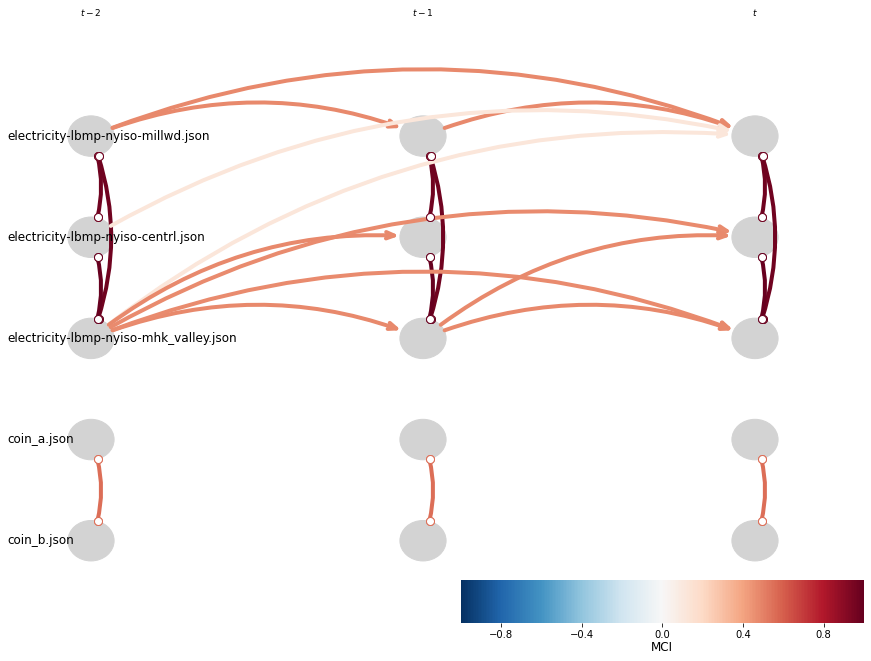

In [ ]:
results = pcmci_parcorr.run_pcmci(tau_max=2, pc_alpha=0.2)
pcmci_parcorr.print_significant_links( p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'], alpha_level = 0.01)
link_matrix = pcmci_parcorr.return_significant_links(pq_matrix=results['p_matrix'],
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']
tp.plot_time_series_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()